In [1]:
!pip install ucimlrepo

In [2]:
# Import Libraries

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# Data

df_obj = fetch_ucirepo(id=544)
X = df_obj.data.features
y = df_obj.data.targets

df = pd.concat([X, y], axis=1)

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['NObeyesdad'].value_counts())
print("\nMissing Values:")
print(df.isnull().sum().sum(), "missing values found")

Dataset Shape: (2111, 17)

Target Distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Missing Values:
0 missing values found


In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# Feature Engineering
df_engineered = df.copy()

# Add BMI
df_engineered['BMI'] = df_engineered['Weight'] / (df_engineered['Height'] ** 2)

# Age groups Binning
df_engineered['Age_Group'] = pd.cut(df_engineered['Age'], bins=[0, 20, 30, 40, 100], labels=['Teen', 'Young', 'Middle', 'Senior'])

print("New features added:")
print(df_engineered[['BMI']].describe())

# Preprocessing
X_eng = df_engineered.drop('NObeyesdad', axis=1)
y_target = df_engineered['NObeyesdad']

categorical_cols = ['Gender', 'CAEC', 'CALC', 'MTRANS', 'Age_Group']
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

X_eng[binary_cols] = X_eng[binary_cols].replace({'yes': 1, 'no': 0})

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    (StandardScaler(), numeric_cols),
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X_eng)

feature_names = (
    preprocessor.named_transformers_['onehotencoder']
    .get_feature_names_out(categorical_cols).tolist()
    + numeric_cols
    + binary_cols
)

X_df = pd.DataFrame(X_preprocessed, columns=feature_names)

le = LabelEncoder()
y_encoded = le.fit_transform(y_target)

print(f"\nPreprocessed shape: {X_df.shape}")
print(f"Number of features: {len(feature_names)}")
print("\nTarget encoding:")
for cls, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"  {cls}: {encoded}")

New features added:
               BMI
count  2111.000000
mean     29.700159
std       8.011337
min      12.998685
25%      24.325802
50%      28.719089
75%      36.016501
max      50.811753

Preprocessed shape: (2111, 27)
Number of features: 27

Target encoding:
  Insufficient_Weight: 0
  Normal_Weight: 1
  Obesity_Type_I: 2
  Obesity_Type_II: 3
  Obesity_Type_III: 4
  Overweight_Level_I: 5
  Overweight_Level_II: 6


In [5]:
custom_order = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

y_encoded = df_engineered['NObeyesdad'].map(custom_order)

In [6]:
feature_names.remove("Age")
feature_names.remove("Weight")

In [7]:
X_df = X_df.drop(columns=['Age', 'Weight'])

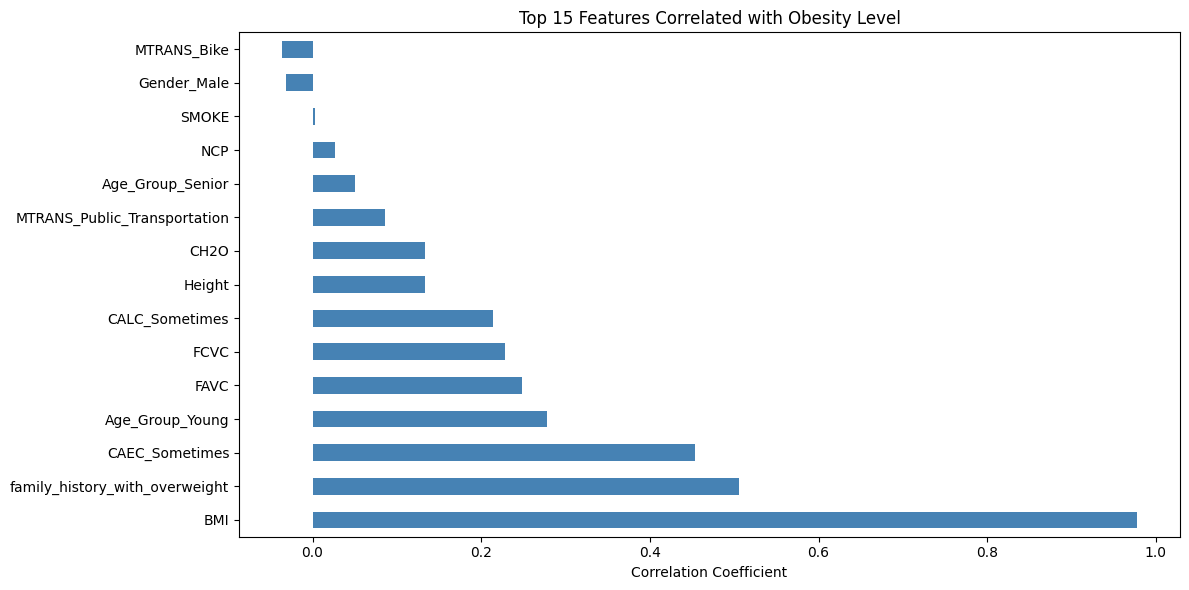


Top 10 Most Correlated Features:
BMI                               0.977826
family_history_with_overweight    0.505148
CAEC_Sometimes                    0.453188
Age_Group_Young                   0.277878
FAVC                              0.247793
FCVC                              0.227759
CALC_Sometimes                    0.214067
Height                            0.133565
CH2O                              0.133008
MTRANS_Public_Transportation      0.085606
Name: Target, dtype: float64


In [8]:
# Feature Correlations

full_df = X_df.copy()
full_df['Target'] = y_encoded

correlations = full_df.corr()['Target'].drop('Target').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_n = 15
correlations.head(top_n).plot(kind='barh', color='steelblue')
plt.title(f'Top {top_n} Features Correlated with Obesity Level')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Correlated Features:")
print(correlations.head(10))

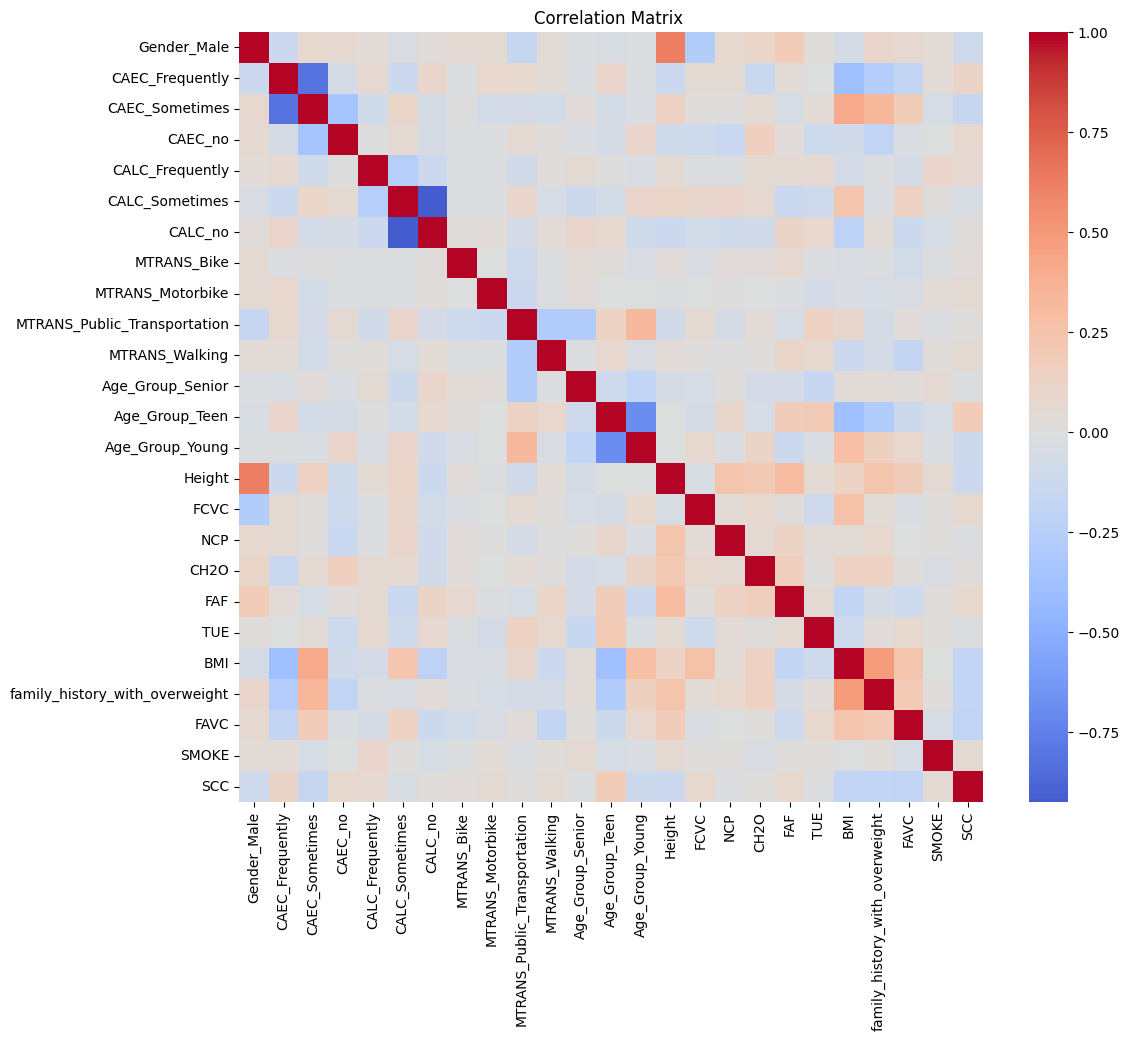

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = full_df.drop(columns=["Target"]).corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix ")
plt.show()

In [10]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Logistic Regression

log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial',
                             class_weight='balanced', random_state=1)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print("Logistic Regression Results")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))


Training set: (1688, 25)
Test set: (423, 25)
Logistic Regression Results
Accuracy: 0.8818
F1 Score: 0.8813

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.98      0.95        54
      Normal_Weight       0.88      0.76      0.81        58
     Obesity_Type_I       0.75      0.76      0.75        58
    Obesity_Type_II       0.77      0.84      0.80        58
   Obesity_Type_III       0.95      0.84      0.89        70
 Overweight_Level_I       0.89      0.98      0.94        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.88       423
          macro avg       0.88      0.88      0.88       423
       weighted avg       0.88      0.88      0.88       423



In [11]:
# KNN with Tuning

print("\nTuning KNN hyperparameters...")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid,
                        cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("KNN Results")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


Tuning KNN hyperparameters...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.8880
KNN Results
Accuracy: 0.9054
F1 Score: 0.9029

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.83      0.98      0.90        54
      Normal_Weight       0.93      0.66      0.77        58
     Obesity_Type_I       0.81      0.86      0.83        58
    Obesity_Type_II       0.93      0.88      0.90        58
   Obesity_Type_III       0.89      0.96      0.92        70
 Overweight_Level_I       0.97      0.98      0.98        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.91       423
          macro avg       0.91      0.90      0.90       423
       weighted avg       0.91      0.91      0.90       423



Decision Tree Results
Accuracy: 0.9362
F1 Score: 0.9363

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.96      0.98        54
      Normal_Weight       0.97      1.00      0.98        58
     Obesity_Type_I       0.86      0.93      0.89        58
    Obesity_Type_II       0.88      0.84      0.86        58
   Obesity_Type_III       0.92      0.93      0.92        70
 Overweight_Level_I       0.96      0.92      0.94        60
Overweight_Level_II       0.98      0.97      0.98        65

           accuracy                           0.94       423
          macro avg       0.94      0.94      0.94       423
       weighted avg       0.94      0.94      0.94       423



<Figure size 1200x600 with 0 Axes>

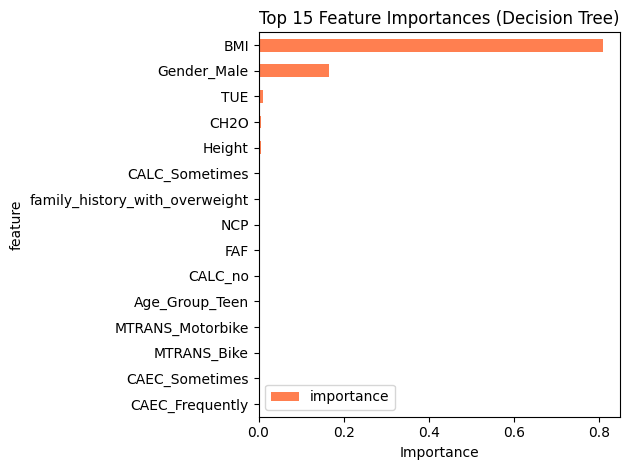

In [12]:
# Decision Tree

dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10,
                           min_samples_leaf=5, class_weight='balanced',
                           random_state=1)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree Results")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

# Feature importance for Decision Tree
feature_importance_dt = pd.DataFrame({
    'feature': feature_names,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
feature_importance_dt.head(15).plot(x='feature', y='importance', kind='barh', color='coral')
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Random Forest Results
Accuracy: 0.9740
F1 Score: 0.9742

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        54
      Normal_Weight       0.91      1.00      0.95        58
     Obesity_Type_I       0.98      0.98      0.98        58
    Obesity_Type_II       1.00      0.98      0.99        58
   Obesity_Type_III       0.96      0.96      0.96        70
 Overweight_Level_I       0.98      0.95      0.97        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.97       423
          macro avg       0.98      0.97      0.97       423
       weighted avg       0.98      0.97      0.97       423



<Figure size 1200x600 with 0 Axes>

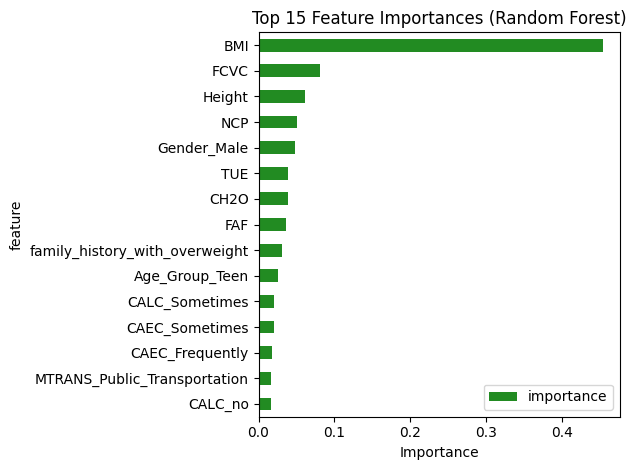

In [13]:
# Random Forest

rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                           min_samples_split=5, class_weight='balanced',
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Results")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', color='forestgreen')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Gradient Boosting

gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1,
                                max_depth=5, random_state=1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print("Gradient Boosting Results")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

Gradient Boosting Results
Accuracy: 0.9716
F1 Score: 0.9717

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.96      0.98        54
      Normal_Weight       0.95      1.00      0.97        58
     Obesity_Type_I       0.97      0.98      0.97        58
    Obesity_Type_II       0.98      0.95      0.96        58
   Obesity_Type_III       0.92      0.99      0.95        70
 Overweight_Level_I       1.00      0.92      0.96        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.97       423
          macro avg       0.97      0.97      0.97       423
       weighted avg       0.97      0.97      0.97       423



In [15]:
# Support Vector Machine

svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM Results")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Results
Accuracy: 0.9551
F1 Score: 0.9554

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.91      0.93        54
      Normal_Weight       0.88      0.86      0.87        58
     Obesity_Type_I       0.86      0.97      0.91        58
    Obesity_Type_II       0.98      0.97      0.97        58
   Obesity_Type_III       1.00      0.97      0.99        70
 Overweight_Level_I       1.00      1.00      1.00        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.96       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.96      0.96      0.96       423



Model Comparision
                     accuracy        f1
Random Forest        0.973995  0.974152
Gradient Boosting    0.971631  0.971652
SVM                  0.955083  0.955367
Decision Tree        0.936170  0.936321
KNN                  0.905437  0.902891
Logistic Regression  0.881797  0.881341


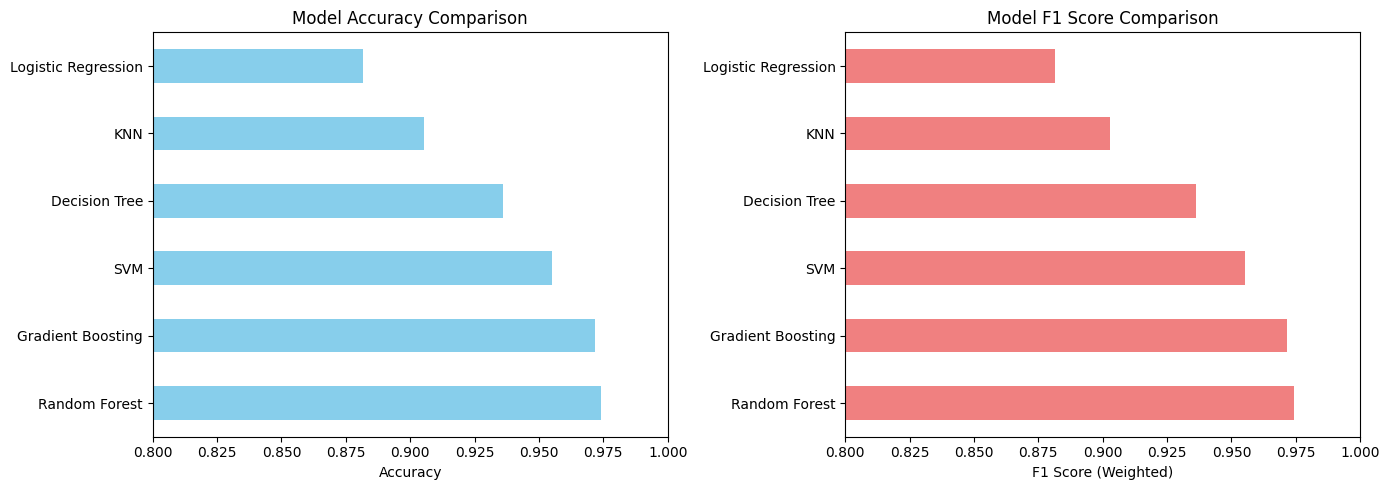

In [16]:
# Model Comparison

results = {
    'Logistic Regression': {'accuracy': accuracy_lr, 'f1': f1_lr},
    'KNN': {'accuracy': accuracy_knn, 'f1': f1_knn},
    'Decision Tree': {'accuracy': accuracy_dt, 'f1': f1_dt},
    'Random Forest': {'accuracy': accuracy_rf, 'f1': f1_rf},
    'Gradient Boosting': {'accuracy': accuracy_gb, 'f1': f1_gb},
    'SVM': {'accuracy': accuracy_svm, 'f1': f1_svm}
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)

print("Model Comparision")
print(results_df.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df['accuracy'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim([0.8, 1.0])

results_df['f1'].plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_xlabel('F1 Score (Weighted)')
axes[1].set_title('Model F1 Score Comparison')
axes[1].set_xlim([0.8, 1.0])

plt.tight_layout()
plt.show()

In [17]:
# Cross-Validation Analysis

print("5-fold Cross Validation")

models_cv = {
    'Logistic Regression': log_reg,
    'KNN': best_knn,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'SVM': svm
}

cv_results = {}
for name, model in models_cv.items():
    scores = cross_val_score(model, X_df, y_encoded, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"\n{name}:")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  Scores: {scores}")

5-fold Cross Validation

Logistic Regression:
  Mean: 0.8816 (+/- 0.1510)
  Scores: [0.73286052 0.93601896 0.90047393 0.92890995 0.90995261]

KNN:
  Mean: 0.8911 (+/- 0.0860)
  Scores: [0.80614657 0.90995261 0.91232227 0.9028436  0.92417062]

Decision Tree:
  Mean: 0.9479 (+/- 0.0718)
  Scores: [0.87706856 0.9549763  0.96919431 0.96682464 0.97156398]

Random Forest:
  Mean: 0.9560 (+/- 0.1478)
  Scores: [0.80851064 0.98578199 0.99052133 0.99763033 0.99763033]

Gradient Boosting:
  Mean: 0.9688 (+/- 0.0424)
  Scores: [0.92907801 0.96445498 0.98578199 0.98104265 0.98341232]

SVM:
  Mean: 0.9484 (+/- 0.1078)
  Scores: [0.84160757 0.97393365 0.96682464 0.97156398 0.98815166]


# Hyperparameter Tuning - Random Forest

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

rand_search.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [10, 15, 20, 30],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=1, scoring='f1_weighted', verbose=2)

In [20]:
print("Best Hyperparameters:")
print(rand_search.best_params_)

print("\nBest CV Weighted F1 Score:")
print(rand_search.best_score_)

Best Hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 20, 'class_weight': 'balanced'}

Best CV Weighted F1 Score:
0.976962066855025


In [21]:
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test Weighted F1:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Test Accuracy: 0.9739952718676123
Test Weighted F1: 0.9740780686144579

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        54
      Normal_Weight       0.92      1.00      0.96        58
     Obesity_Type_I       0.97      0.98      0.97        58
    Obesity_Type_II       1.00      0.98      0.99        58
   Obesity_Type_III       0.96      0.96      0.96        70
 Overweight_Level_I       0.98      0.95      0.97        60
Overweight_Level_II       1.00      1.00      1.00        65

           accuracy                           0.97       423
          macro avg       0.98      0.97      0.97       423
       weighted avg       0.97      0.97      0.97       423



# Hyperparameter Tuning-Gradient Boosting

In [22]:
param_grid_gb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6]
}

In [23]:
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=1)

gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_weighted', verbose=2)

In [24]:
print("Best Parameters:", gb_grid.best_params_)
print("Best CV Weighted F1:", gb_grid.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best CV Weighted F1: 0.976830982405598


In [25]:
best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred_gb))
print("Weighted F1:", f1_score(y_test, y_pred_gb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))


Accuracy: 0.9763593380614657
Weighted F1: 0.976370407393

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        54
      Normal_Weight       0.97      1.00      0.98        58
     Obesity_Type_I       0.97      0.98      0.97        58
    Obesity_Type_II       0.98      0.95      0.96        58
   Obesity_Type_III       0.95      0.99      0.97        70
 Overweight_Level_I       0.98      0.95      0.97        60
Overweight_Level_II       1.00      0.98      0.99        65

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      0.98      0.98       423



In [26]:
import numpy as np
import pandas as pd

importances = best_gb.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(15))

                           Feature  Importance
20                             BMI    0.871709
0                      Gender_Male    0.091794
14                          Height    0.009969
16                             NCP    0.007618
19                             TUE    0.007121
15                            FCVC    0.004105
11                Age_Group_Senior    0.001335
17                            CH2O    0.001285
6                          CALC_no    0.001059
21  family_history_with_overweight    0.001004
5                   CALC_Sometimes    0.000735
18                             FAF    0.000537
9     MTRANS_Public_Transportation    0.000400
24                             SCC    0.000360
22                            FAVC    0.000324


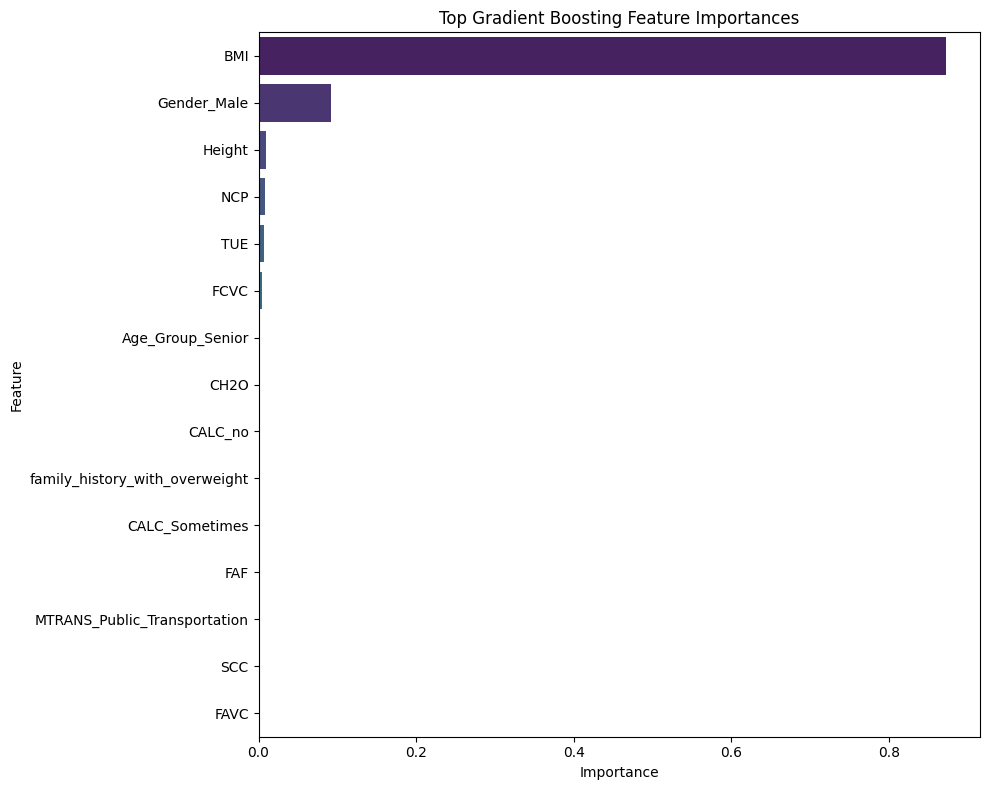

In [27]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(15),
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Top Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()